In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

import youtokentome as yttm

import utils
from utils.base import get_params_number, train_loop, init_random_seed, save_texts_to_file
from utils.poetry import LanguageModelDataset, load_chunks, GreedyGenerator, BeamGenerator
from utils.transformer_tools import *

init_random_seed(1702)

In [2]:
# # Предобработка изначального файла, кодировка, уничтожение пустых строк

# with open("datasets/DarkTower/DT14.txt", encoding="utf-8") as input_file:
#     horus = input_file.read().split('\n')
#     horus = [value for value in horus if value != ""]
#     # horus = [value.replace(u'\xa0', u' ') for value in horus]

# with open("datasets/DarkTower/DT14_red.txt", "w", encoding="utf-8") as f:
#     for line in horus:
#         f.write(f"{line}\n")

In [2]:
horus = load_chunks("./datasets/DarkTower/DT14_red.txt", chunk_size=300)

ALL_LEN = len(horus)
print(ALL_LEN)
len_for_steps = int(ALL_LEN / 3)
horus_for_GAN = horus[len_for_steps * 2:]
horus = horus[:len_for_steps * 2]
print(len(horus))
print(len(horus_for_GAN))

22507
15004
7503


In [3]:
horus_train, horus_test = train_test_split(horus, test_size=0.3)

print('Размер обучающей выборки', len(horus_train))
print('Размер валидационной выборки', len(horus_test))

Размер обучающей выборки 10502
Размер валидационной выборки 4502


In [4]:
BPE_MODEL_FILENAME = './models/tokens/dt_bpe_2000.yttm'

# TRAIN_TEXTS_FILENAME = './datasets/DarkTower/dt_train.txt'
# save_texts_to_file(horus, TRAIN_TEXTS_FILENAME)
# yttm.BPE.train(data=TRAIN_TEXTS_FILENAME, vocab_size=2000, model=BPE_MODEL_FILENAME)

tokenizer = yttm.BPE(BPE_MODEL_FILENAME)
print(' '.join(tokenizer.vocab()))

<PAD> <UNK> <BOS> <EOS> ▁ e t a o n h i s d r l u w g c m f y . b , p k v T I E H “ ’ ” A S - " R O ? ' N W B D J Y M C L x z ! j G F … ; U P q : K ) ( V ­ — 1 – 2 3 4 9 5 7 0 Q 6 8 X Z / ‘ $ * » ^ \ # + « ~ _ ] [ & ▁t he ▁a in ▁s ▁the ▁w ▁o ▁h nd ed ▁b er ou ing re ▁f it ▁c at is ▁d ▁l ▁m as en ▁th ▁and ▁to ▁of ▁he ll an ▁g ar ad es on or ▁p ▁in ▁n ▁T ▁was id ow ▁be om ut ▁it gh ld ▁y ot ▁on le ke ▁e ▁“ ac ▁his ▁I im ly ▁st ▁H us and ic ▁r ▁had ▁you oo un ▁The ght ie et ay ▁that ▁wh ve dd al ▁S ver ▁sa os ▁as ▁E ir ol ▁re ▁He ith ▁A ould ▁at ’s ain ight ▁with ▁R ur ent ked ddie ▁Eddie el ▁him e. her ▁k ake am ▁sh ▁for ▁B ▁u ▁J ▁li ▁but e, ▁an ter all ack ▁" ▁said ▁ha ▁se ▁her oland ▁not ▁Roland ling s. pp ill ch ▁fr st ▁loo ▁do if ion s, ▁gun ▁W ▁Jake ard .” ▁kn ▁M ome ore ▁up ’t ▁like ▁she ust il ed. ▁whe ere ▁O ▁C ound ▁al th ▁out ell ▁guns ▁j ▁tr ant ▁from ind ▁all ro ▁one ck ▁were linger ▁this ▁they ▁gunslinger um em ▁been ▁them ▁would ▁have ▁ne ▁bl ▁le ▁ag to ap ?” hed ▁D ▁su ood

In [5]:
train_token_ids = tokenizer.encode(horus_train, bos=True, eos=True)
test_token_ids = tokenizer.encode(horus_test, bos=True, eos=True)

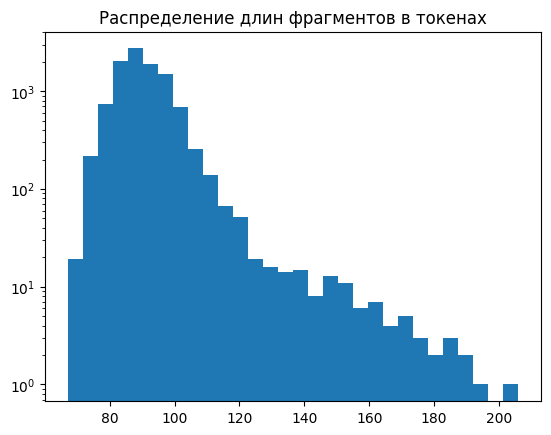

In [6]:
plt.hist([len(sent) for sent in train_token_ids], bins=30)
plt.title('Распределение длин фрагментов в токенах')
plt.yscale('log')

In [7]:
unknown_subwords_in_test = sum(1 for text in test_token_ids for token_id in text if token_id == 1)
print('Количество случаев с неизвестными n-граммами символов в валидационной выборке', unknown_subwords_in_test)

Количество случаев с неизвестными n-граммами символов в валидационной выборке 0


In [8]:
CHUNK_LENGTH = 100

train_dataset = LanguageModelDataset(train_token_ids, chunk_length=CHUNK_LENGTH)
test_dataset = LanguageModelDataset(test_token_ids, chunk_length=CHUNK_LENGTH)

In [9]:
tokenizer.decode(list(train_dataset[500]))

["<BOS> red a woman like that deserved just what she got. Thing was, she was also a rich nigger. Thing was, she was almost as well-known to the American public as Medgar Evers or Martin Luther King. Thing was, she'd gotten her rich nigger face on the cover of Time magazine and it was a little harder to get<PAD><PAD><PAD><PAD>",
 "red a woman like that deserved just what she got. Thing was, she was also a rich nigger. Thing was, she was almost as well-known to the American public as Medgar Evers or Martin Luther King. Thing was, she'd gotten her rich nigger face on the cover of Time magazine and it was a little harder to get<EOS><PAD><PAD><PAD><PAD>"]

In [10]:
model = Language_Model(
    vocab_size = tokenizer.vocab_size(),
    embedding_size = 512,
    backbone = Transformer_Encoder(
        nn.TransformerEncoderLayer(
            d_model = 512,
            nhead = 16,
            dim_feedforward = 1024,
            dropout = 0.3
        ),
        num_layers=5
    ),
    emb_dropout = 0.2
)
print('Количество параметров', get_params_number(model))

Количество параметров 12563920


In [20]:
loss_history_all, best_model, optimizer = train_loop(
    model,
    train_dataset,
    test_dataset,
    lm_cross_entropy,
    # save_path="./models/My_models/War/war_2/",
    need_to_save=False,
    lr=1e-4,
    epoch_n=2000,
    batch_size=128,
    device='cuda',
    early_stopping_patience=50,
    # early_optimizer_SD=optimizer_SD,
    max_batches_per_epoch_train=1000,
    max_batches_per_epoch_val=1000,
    lr_scheduler_ctor=lr_scheduler,
    need_to_gen=True,
    tokenizer=tokenizer,
    phrase="The Dark Tower was "
)

Эпоха 0
Эпоха: 83 итераций, 14.08 сек
Среднее значение функции потерь на обучении 6.637139423784003
Среднее значение функции потерь на валидации 6.542551226086086
Новая лучшая модель!
The Dark Tower was a the of the f the f the gunslinger of the f of the f of the f the gunslinger of the gunslinger of the gunslinger of the gunslinger of the gunslinger of the f the gunslinger of the gunslinger

Эпоха 1
Эпоха: 83 итераций, 13.06 сек
Среднее значение функции потерь на обучении 6.435675689973027
Среднее значение функции потерь на валидации 6.165779047542149
Новая лучшая модель!
The Dark Tower was the gunslinger. He was the gunslinger. He was a gunslinger. He was the gunslinger. He was a gunslinger. The gunslinger. The gunslinger. The gunslinger. He was the gunslinger. He had been

Эпоха 2
Эпоха: 83 итераций, 13.87 сек
Среднее значение функции потерь на обучении 6.111397662794734
Среднее значение функции потерь на валидации 5.8221653832329645
Новая лучшая модель!
The Dark Tower was a gunslin

In [22]:
torch.save(best_model.state_dict(), "./models/Lord/DT/1/Lord.pth")
torch.save(optimizer.state_dict(), './models/Lord/DT/1/Lord_opt.pth')

In [23]:
loss_history_all = [str(line) for line in loss_history_all]
save_texts_to_file(loss_history_all, "./models/Lord/DT/1/Lord_1.txt")

### Генерация текста

In [11]:
optimizer_SD = torch.load('./models/Lord/DT/1/Lord_opt.pth')
model.load_state_dict(torch.load('./models/Lord/DT/1/Lord.pth'))

<All keys matched successfully>

In [12]:
beam_generator = BeamGenerator(model, tokenizer)

In [13]:
answers = []
for i in range(5):
    beam_gen_variants = beam_generator('In the middle of', beamsize=5, return_hypotheses_n=1, temperature=0.5, alpha=0.3, need_reweight=True)
    for score, pred_txt in beam_gen_variants:
        answers.append(pred_txt)

for ans in answers:
    print(ans)

In the middle of the months ago, as well as they passed in the spring-point in the fourth of The Street of the Fifth and Forty Central P
In the middle of four legs. The dress-carriage was replaced by a lunch. The firs had been swooped down on the cornp of paper-poss and the py
In the middle of his broad, reaching out of his long-vio. It was a tiny radar-dish grace marble on the roof of his own makings. It was
In the middle of the book. The Mercad Folgy enough to Road Fat Johnny Had, who has been incredulative; there is a few state,
In the middle of Polategogue Box Bamin Hy Marviscoon, but it was just the same. "Guy killed my Final Essay


In [27]:
answers = []
for i in range(5):
    beam_gen_variants = beam_generator('The Dark Tower was', beamsize=5, return_hypotheses_n=1, temperature=0.8, alpha=0.15, need_reweight=False)
    for score, pred_txt in beam_gen_variants:
        answers.append(pred_txt)

for ans in answers:
    print(ans)

The Dark Tower was temporated with a single shot, devil-grass, a river, Biggie. And a 7 Two on the morning roof of Pl
The Dark Tower was a grove of tree.” “AND WOME HOPEKED THE FRONER. I ALL RIDDLES OF THE NEXT MATER
The Dark Tower was some-those." The flattened guts out of the leaning stone steps. The Mansion, a little failing sound came to a grinding sound. The
The Dark Tower was a recognnization,” Roland said. “One of the Dark Tower,” Roland ed, ignoring Mort dim Mortcated insase that Mortcypedia 
The Dark Tower was fed to find a jocular silvery block: Four Forty-seconde-sixthday, the seven incredibly in the last of the


In [15]:
answers = []
for i in range(5):
    beam_gen_variants = beam_generator('For the king and ', beamsize=5, return_hypotheses_n=1, temperature=0.5, alpha=0.3, need_reweight=True)
    for score, pred_txt in beam_gen_variants:
        answers.append(pred_txt)

for ans in answers:
    print(ans)

For the king and the first time in year. The gunslinger had no —as nearly as an —oney now that Mortcypedia. Propted painted to the push out
For the king and tenanted for the Barony of the Coach. He watched the old dreads fired and watched as Jake as he watched the mountains. “There,” the gunslinger said. “The ha
For the king and then pieed for the first time. “There was a man on’t many Boys are,” Moreaye reading in End-World Riddle-De-De-
For the king and the far end of the Tower. Western Sea plant of the Western Sea. Pubes above somewhere in the crack of the explosions and ter
For the king and then put it in a jagged ceiling. The fingers swayed open. "Will no one!" Detta yelled just mutterly at the end of the same time … and then


In [16]:
answers = []
for i in range(5):
    beam_gen_variants = beam_generator('We are going to  ', beamsize=5, return_hypotheses_n=1, temperature=0.5, alpha=0.3, need_reweight=True)
    for score, pred_txt in beam_gen_variants:
        answers.append(pred_txt)

for ans in answers:
    print(ans)

We are going to take on our way, as if you were going to get a different Junkie kid. From out of the hidesick-159 MORREAYME
We are going to bring them a course of police car. Pubes and surged in the streets, but they must have some sort of problemn in the problems which sur
We are going to platform, and then it’s goan be sure as far as a man can be. Why do we don’t know. I goan be sure it’s not sure, and that you don’t know
We are going to kill him by the answer.” “YES.” “OF ONE,” Blaine replied. His voice was soft, his it clear and responding with pleasantly-the angry human
We are going to the pool. I believe someone’s the Drawing’s maybe even get out here and give it to me someplace, ain’t no doubt for sure?” “Blaine:
